# Model testing

Now that all the metadata has been studied some testing with models from diferent sources and original code will be undergone in order to define some models to send to the boada environment.

We will start slow with simple pre-trained models extracted directly from the pytorch environment and build from those up with the modifications that we want to study in the experimentation. Mainly the models tested will be ResNet (in some of it's variants) and some DensNet variants at first with the option of further models if everything goes to plan.

Another objective would be to try to test the difference between transfer learning and full training from scratch, considering some other more sophisticated learning methods like one-shot if there is time.

Finally some degree of localization will be accquired with the advancements of the paper from Selvaraju et al. of Grad-CAM.  Code will be recicled with the original paper code with the necessary modifications in order to apply it to the selected models of the project.


## Preparing the split between test, train and validation

In [6]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

def undersample_negatives(train_data, labels, ratio=0.3):
    
    negative = train_data[train_data['No Finding'] == 1]
    positive = train_data[train_data['No Finding'] == 0]
    
    negative = resample(negative, 
                        replace=False,
                        n_samples=int(len(positive)*(ratio / (1- ratio))), # reduce as stated in ratio
                        random_state=42)
    
    return pd.concat([positive, negative])

ratio = 0.3

# Get the labels and read the original metadata
labels = ['No Finding',
          'Atelectasis',
          'Cardiomegaly',
          'Consolidation',
          'Edema',
          'Effusion',
          'Emphysema',
          'Fibrosis',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Pleural_Thickening',
          'Pneumonia',
          'Pneumothorax']

metadata = pd.read_csv('Data_Entry_2017_v2020.csv', delimiter=',')

# Encode the labels with multi-label friendly encoding
for label in labels:
    metadata[label] = metadata['Finding Labels'].apply(lambda x: 1 if label in x else 0)

metadata = metadata.drop(columns=['Finding Labels', 'Follow-up #','Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width','Height]', 'OriginalImagePixelSpacing[x', 'y]'])

# Get the test train and val splits according to the patient ID so no patients end up split between groups
gss_test = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_val_idx, test_idx = next(gss_test.split(metadata, groups=metadata['Patient ID']))

train_val_metadata = metadata.iloc[train_val_idx]
test_metadata = metadata.iloc[test_idx]

gss_train_val = GroupShuffleSplit(test_size=0.125, n_splits=1, random_state=42)
train_idx, val_idx = next(gss_train_val.split(train_val_metadata, groups=train_val_metadata['Patient ID']))

train_metadata = train_val_metadata.iloc[train_idx]
val_metadata = train_val_metadata.iloc[val_idx]


# Drop the column of patient ID
train_metadata = train_metadata.drop(columns=['Patient ID'])
val_metadata = val_metadata.drop(columns=['Patient ID'])
test_metadata = test_metadata.drop(columns=['Patient ID'])


# Undersample "No Findings"
train_metadata = undersample_negatives(train_metadata,labels,ratio)
val_metadata = undersample_negatives(val_metadata,labels,ratio)
test_metadata = undersample_negatives(test_metadata,labels,ratio)


#Write all the new metadata as csv to load easier
train_metadata.to_csv('./labels/train_metadata.csv', index=False)
val_metadata.to_csv('./labels/val_metadata.csv', index=False)
test_metadata.to_csv('./labels/test_metadata.csv', index=False)

In [7]:
print(f'in terms of all train: {len(train_metadata)}, val: {len(val_metadata)}, test: {len(test_metadata)} and total: {len(train_metadata) + len(test_metadata) + len(val_metadata) }')

in terms of all train: 52205, val: 7012, test: 14722 and total: 73939



## Dataset definition and load (dataset.py)

We define the dataset and load from the data entries

In [3]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image

class ChestXRay(Dataset):
    def __init__(self, df_dir, image_dir, transform=None):
        """
        Args:
            df_dir: Path to the csv file with image names and labels.
            image_dir: Directory with all the images with the labels.
            transform: Optional transform to be applied on a sample.
        """
        self.classes = ['No Finding',
                        'Atelectasis',
                        'Cardiomegaly',
                        'Consolidation',
                        'Edema',
                        'Effusion',
                        'Emphysema',
                        'Fibrosis',
                        'Hernia',
                        'Infiltration',
                        'Mass',
                        'Nodule',
                        'Pleural_Thickening',
                        'Pneumonia',
                        'Pneumothorax']

        
        self.data_frame = pd.read_csv(df_dir)
        self.image_dir = image_dir
        self.transform = transform

        self.size = len(self.data_frame)
        self.labels = np.array(self.data_frame.iloc[:, 1:])
        self.images = self.data_frame.iloc[:,0]
        self.class_count = self.labels.sum(0)
        self.total_labels = self.class_count.sum()
        
        
        

    def __getitem__(self, idx):
        # Get image path
        img_name = os.path.join(self.image_dir, self.images.iloc[idx])
        image = Image.open(img_name).convert("RGB")
        
        # Get labels
        labels = np.array(self.labels[idx])
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        image = np.array(image)
        
        return {'image': image, 'labels': labels}
    
    def __len__(self):
        return self.size

Small testing for the upper function

In [4]:
train_csv = './labels/train_metadata.csv'
val_csv = './labels/val_metadata.csv'
image_dir = '../resized_images'

from torchvision import transforms
from torch.utils.data import DataLoader

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    normalize
    ])

train_dataset = ChestXRay(df_dir=train_csv, image_dir=image_dir, transform=train_transforms)

print(train_dataset.class_count)
print(train_dataset.total_labels)
print(train_dataset.size)

[15661  8262  1863  3280  1639  9533  1727  1145   158 13868  4199  4415
  2424   982  3841]
72997
52205


## Various functions (utils.py)



In [14]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import os

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])


def make_data_loaders(train_csv,val_csv,image_dir,batch_size,image_size):
    

    train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    normalize
    ])

    val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    normalize
    ])

    train_dataset = ChestXRay(df_dir=train_csv, image_dir=image_dir, transform=train_transforms)
    val_dataset = ChestXRay(df_dir=val_csv, image_dir=image_dir, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return {'train': train_loader, 'val': val_loader}, {'train':len(train_dataset),'val':len(val_dataset)}, train_dataset.class_count

In [6]:
import torch
import os

def LoadModel(checkpoint_file, model, optimizer, epoch_inti, num_GPU):
    '''
    The loads the model, optimizer, current epoch, and current validation AUC from the checkpoint location provided.

    Parameters
    ----------
    checkpoint_file: (str) the location of the model in s/m
    model: PyTorch model
    optimizer: PyTorch optimizer
    epoch_inti: current epoch
    num_GPU : (int) number of GPUs that are being used

    Returns
    -------
    Returns the model, optimizer, epoch_inti, best_auc_ave from the saved location.
    '''
    checkpoint = torch.load(checkpoint_file)
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_inti = checkpoint['epoch']
    if num_GPU > 1:
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    return model, optimizer, epoch_inti


def SaveModel(model, optimizer, epoch, file_name, num_GPU):
    """
    Save the model parameters, optimizer, best_AUC

    Parameters
    ----------
    epoch : (int) current epoch
    model : Pytorch model to save
    optimizer : Pytorch optimzer to save
    file_name : (str) location where the model needed to be saved
    num_GPU : (int) number of GPUs that are being used

    """
    if num_GPU > 1:
        state = {
            'epoch': epoch,
            'model_state_dict': model.module.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    else:
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    torch.save(state, file_name)
    pass

In [7]:
import torch
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, steps=1000, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())  # Keep track of best model weights
    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    epochs_without_improvement = 0  # Counter for epochs without improvement

    # Define the learning rate scheduler (reduce LR on plateau)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    val_losses = []  # List to store validation losses for plotting

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training loop
        for i, batch in enumerate(train_loader):
            if i >= steps:  # Break after the defined number of steps
                break
            images = batch['image'].to(device)
            labels = batch['labels'].to(device).float()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation at the end of each epoch
        val_loss = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)  # Log the validation loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            print(f'No improvement in validation loss for {epochs_without_improvement} epoch(s).')

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epochs_without_improvement} epochs without improvement.')
            break

        # Update the learning rate based on validation loss
        scheduler.step(val_loss)

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    print('Training complete. Best Validation Loss:', best_val_loss)
    
    return model, val_losses  # Return the model and the validation losses

def validate_model(model, val_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device).float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)  # Return average validation loss

## Test function

Test function that generates the testing values that are necessary for the evaluation of the dataset.

In [8]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    threshold = 0.5  # Threshold for multi-label classification
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > threshold).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

## Models

In [11]:
torch.cuda.is_available()

True

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, DenseNet121_Weights

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10
iter_per_epoch = 1000
image_size = 244

# Paths
train_csv = './labels/train_metadata.csv'
val_csv = './labels/val_metadata.csv'
image_dir = '../resized_images'
num_classes = 15

# Data Loaders

dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv,val_csv,image_dir,batch_size,image_size)

# Model
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
parameters = resnet18.parameters()
optimizer = get_optimizer(parameters,'Adam',learning_rate)

# Train the model
train_model(resnet18, dataloaders['train'], dataloaders['val'], criterion, optimizer, num_epochs)

c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting epoch 1/10
Epoch [1/10], Validation Loss: 0.2628
Starting epoch 2/10
Epoch [2/10], Validation Loss: 0.2574
Starting epoch 3/10
Epoch [3/10], Validation Loss: 0.2527
Starting epoch 4/10
Epoch [4/10], Validation Loss: 0.2555
No improvement in validation loss for 1 epoch(s).
Starting epoch 5/10
Epoch [5/10], Validation Loss: 0.2524
Starting epoch 6/10
Epoch [6/10], Validation Loss: 0.2501
Starting epoch 7/10
Epoch [7/10], Validation Loss: 0.2455
Starting epoch 8/10
Epoch [8/10], Validation Loss: 0.2427
Starting epoch 9/10
Epoch [9/10], Validation Loss: 0.2426
Starting epoch 10/10
Epoch [10/10], Validation Loss: 0.2442
No improvement in validation loss for 1 epoch(s).
Training complete. Best Validation Loss: 0.24259787047778283


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

## Testing for the best Optimizer

In [9]:
from torch.optim import SGD, Adadelta, Adam, RMSprop, AdamW

def get_optimizer(params, optimizer, lr=1e-4, momentum=0.9, weight_decay=0.0):
    """
    Loads and returns the optimizer.
    """
    if optimizer == 'SGD':
        return SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer == 'SGD_Nesterov':
        return SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    elif optimizer == 'Adadelta':
        return Adadelta(params, lr=lr, weight_decay=weight_decay)
    elif optimizer == 'Adam':
        return Adam(params, lr=lr, weight_decay=weight_decay)
    elif optimizer == 'AdamW':
        return AdamW(params, lr=lr, weight_decay=weight_decay)
    elif optimizer == 'RMSprop':
        return RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        raise Exception('Unknown optimizer : {}'.format(optimizer))

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import ResNet18_Weights

def test_optimizer(opt_name, val_losses_storage):
    # Hyperparameters
    batch_size = 16
    learning_rate = 0.001
    num_epochs = 25
    steps_per_epoch = 500
    image_size = 256
    num_classes = 15

    # Paths
    train_csv = './labels/train_metadata.csv'
    val_csv = './labels/val_metadata.csv'
    image_dir = './resized_images'

    # Data Loaders
    dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    print(f'Testing optimizer: {opt_name}')

    # Model initialization
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Get the optimizer
    parameters = model.parameters()
    optimizer = get_optimizer(parameters, opt_name, learning_rate)

    # Train the model and get validation losses
    _, val_losses = train_model(model, dataloaders['train'], dataloaders['val'], criterion, optimizer, num_epochs, steps_per_epoch)

    # Store validation losses for this optimizer
    val_losses_storage[opt_name] = val_losses

    return val_losses_storage


In [52]:
import matplotlib.pyplot as plt

def plot_losses(val_losses, message):
    plt.figure(figsize=(10, 6))

    for name, val_losses in val_losses.items():
        plt.plot(val_losses, label=f'{name}')

    plt.title(message)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
val_losses_storage = {}

In [44]:
# Testing SGD optimizer
val_losses_storage = test_optimizer('SGD', val_losses_storage)

Testing optimizer: SGD


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting epoch 1/25
Epoch [1/25], Validation Loss: 0.3038
Starting epoch 2/25
Epoch [2/25], Validation Loss: 0.2992
Starting epoch 3/25
Epoch [3/25], Validation Loss: 0.2963
Starting epoch 4/25
Epoch [4/25], Validation Loss: 0.2939
Starting epoch 5/25
Epoch [5/25], Validation Loss: 0.2927
Starting epoch 6/25
Epoch [6/25], Validation Loss: 0.2910
Starting epoch 7/25
Epoch [7/25], Validation Loss: 0.2895
Starting epoch 8/25
Epoch [8/25], Validation Loss: 0.2874
Starting epoch 9/25
Epoch [9/25], Validation Loss: 0.2855
Starting epoch 10/25
Epoch [10/25], Validation Loss: 0.2844
Starting epoch 11/25
Epoch [11/25], Validation Loss: 0.2836
Starting epoch 12/25
Epoch [12/25], Validation Loss: 0.2828
Starting epoch 13/25
Epoch [13/25], Validation Loss: 0.2824
Starting epoch 14/25
Epoch [14/25], Validation Loss: 0.2797
Starting epoch 15/25
Epoch [15/25], Validation Loss: 0.2800
No improvement in validation loss for 1 epoch(s).
Starting epoch 16/25
Epoch [16/25], Validation Loss: 0.2790
Starting

In [45]:
# Testing SGD optimizer
val_losses_storage = test_optimizer('SGD_Nesterov', val_losses_storage)

Testing optimizer: SGD_Nesterov
Starting epoch 1/25


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Validation Loss: 0.3039
Starting epoch 2/25
Epoch [2/25], Validation Loss: 0.2996
Starting epoch 3/25
Epoch [3/25], Validation Loss: 0.2957
Starting epoch 4/25
Epoch [4/25], Validation Loss: 0.2925
Starting epoch 5/25
Epoch [5/25], Validation Loss: 0.2904
Starting epoch 6/25
Epoch [6/25], Validation Loss: 0.2898
Starting epoch 7/25
Epoch [7/25], Validation Loss: 0.2862
Starting epoch 8/25
Epoch [8/25], Validation Loss: 0.2855
Starting epoch 9/25
Epoch [9/25], Validation Loss: 0.2839
Starting epoch 10/25
Epoch [10/25], Validation Loss: 0.2832
Starting epoch 11/25
Epoch [11/25], Validation Loss: 0.2822
Starting epoch 12/25
Epoch [12/25], Validation Loss: 0.2805
Starting epoch 13/25
Epoch [13/25], Validation Loss: 0.2795
Starting epoch 14/25
Epoch [14/25], Validation Loss: 0.2787
Starting epoch 15/25
Epoch [15/25], Validation Loss: 0.2770
Starting epoch 16/25
Epoch [16/25], Validation Loss: 0.2768
Starting epoch 17/25
Epoch [17/25], Validation Loss: 0.2767
Starting epoch 18/

In [46]:
# Testing SGD optimizer
val_losses_storage = test_optimizer('Adadelta', val_losses_storage)

Testing optimizer: Adadelta
Starting epoch 1/25


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Validation Loss: 0.4281
Starting epoch 2/25
Epoch [2/25], Validation Loss: 0.3374
Starting epoch 3/25
Epoch [3/25], Validation Loss: 0.3157
Starting epoch 4/25
Epoch [4/25], Validation Loss: 0.3103
Starting epoch 5/25
Epoch [5/25], Validation Loss: 0.3081
Starting epoch 6/25
Epoch [6/25], Validation Loss: 0.3068
Starting epoch 7/25
Epoch [7/25], Validation Loss: 0.3060
Starting epoch 8/25
Epoch [8/25], Validation Loss: 0.3054
Starting epoch 9/25
Epoch [9/25], Validation Loss: 0.3049
Starting epoch 10/25
Epoch [10/25], Validation Loss: 0.3043
Starting epoch 11/25
Epoch [11/25], Validation Loss: 0.3037
Starting epoch 12/25
Epoch [12/25], Validation Loss: 0.3031
Starting epoch 13/25
Epoch [13/25], Validation Loss: 0.3029
Starting epoch 14/25
Epoch [14/25], Validation Loss: 0.3024
Starting epoch 15/25
Epoch [15/25], Validation Loss: 0.3021
Starting epoch 16/25
Epoch [16/25], Validation Loss: 0.3016
Starting epoch 17/25
Epoch [17/25], Validation Loss: 0.3013
Starting epoch 18/

In [47]:
# Testing SGD optimizer
val_losses_storage = test_optimizer('Adam', val_losses_storage)

Testing optimizer: Adam
Starting epoch 1/25


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Validation Loss: 0.3198
Starting epoch 2/25
Epoch [2/25], Validation Loss: 0.3067
Starting epoch 3/25
Epoch [3/25], Validation Loss: 0.3009
Starting epoch 4/25
Epoch [4/25], Validation Loss: 0.2993
Starting epoch 5/25
Epoch [5/25], Validation Loss: 0.2936
Starting epoch 6/25
Epoch [6/25], Validation Loss: 0.2985
No improvement in validation loss for 1 epoch(s).
Starting epoch 7/25
Epoch [7/25], Validation Loss: 0.3047
No improvement in validation loss for 2 epoch(s).
Starting epoch 8/25
Epoch [8/25], Validation Loss: 0.2973
No improvement in validation loss for 3 epoch(s).
Starting epoch 9/25
Epoch [9/25], Validation Loss: 0.2920
Starting epoch 10/25
Epoch [10/25], Validation Loss: 0.2862
Starting epoch 11/25
Epoch [11/25], Validation Loss: 0.2864
No improvement in validation loss for 1 epoch(s).
Starting epoch 12/25
Epoch [12/25], Validation Loss: 0.2873
No improvement in validation loss for 2 epoch(s).
Starting epoch 13/25
Epoch [13/25], Validation Loss: 0.2798
Starting

In [48]:
# Testing SGD optimizer
val_losses_storage = test_optimizer('AdamW', val_losses_storage)

Testing optimizer: AdamW
Starting epoch 1/25


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Validation Loss: 0.3027
Starting epoch 2/25
Epoch [2/25], Validation Loss: 0.3036
No improvement in validation loss for 1 epoch(s).
Starting epoch 3/25
Epoch [3/25], Validation Loss: 0.3138
No improvement in validation loss for 2 epoch(s).
Starting epoch 4/25
Epoch [4/25], Validation Loss: 0.2992
Starting epoch 5/25
Epoch [5/25], Validation Loss: 0.2934
Starting epoch 6/25
Epoch [6/25], Validation Loss: 0.2937
No improvement in validation loss for 1 epoch(s).
Starting epoch 7/25
Epoch [7/25], Validation Loss: 0.2941
No improvement in validation loss for 2 epoch(s).
Starting epoch 8/25
Epoch [8/25], Validation Loss: 0.2925
Starting epoch 9/25
Epoch [9/25], Validation Loss: 0.2901
Starting epoch 10/25
Epoch [10/25], Validation Loss: 0.2952
No improvement in validation loss for 1 epoch(s).
Starting epoch 11/25
Epoch [11/25], Validation Loss: 0.3069
No improvement in validation loss for 2 epoch(s).
Starting epoch 12/25
Epoch [12/25], Validation Loss: 0.3147
No improvement in 

In [49]:
# Testing SGD optimizer
val_losses_storage = test_optimizer('RMSprop', val_losses_storage)

Testing optimizer: RMSprop
Starting epoch 1/25


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Validation Loss: 0.3205
Starting epoch 2/25
Epoch [2/25], Validation Loss: 0.3089
Starting epoch 3/25
Epoch [3/25], Validation Loss: 0.5201
No improvement in validation loss for 1 epoch(s).
Starting epoch 4/25
Epoch [4/25], Validation Loss: 0.3112
No improvement in validation loss for 2 epoch(s).
Starting epoch 5/25
Epoch [5/25], Validation Loss: 0.3015
Starting epoch 6/25
Epoch [6/25], Validation Loss: 0.3050
No improvement in validation loss for 1 epoch(s).
Starting epoch 7/25
Epoch [7/25], Validation Loss: 0.2999
Starting epoch 8/25
Epoch [8/25], Validation Loss: 0.3001
No improvement in validation loss for 1 epoch(s).
Starting epoch 9/25
Epoch [9/25], Validation Loss: 0.3000
No improvement in validation loss for 2 epoch(s).
Starting epoch 10/25
Epoch [10/25], Validation Loss: 0.3029
No improvement in validation loss for 3 epoch(s).
Starting epoch 11/25
Epoch [11/25], Validation Loss: 0.3028
No improvement in validation loss for 4 epoch(s).
Starting epoch 12/25
Epoch [

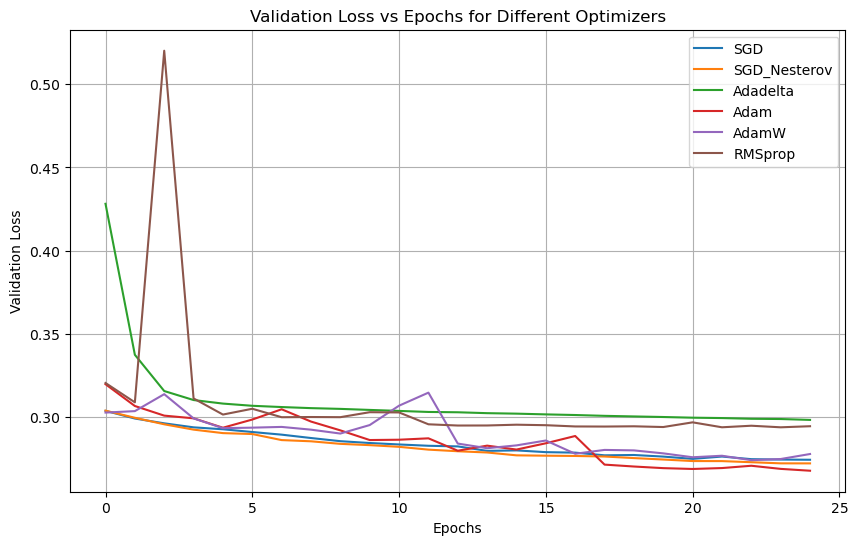

In [50]:
plot_losses(val_losses_storage)

## Testing for the best learning rate and batch size combination

In [47]:
import torch
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
import time
import numpy as np

def train_model_logs(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, steps=1000, patience=5):
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Define the learning rate scheduler (reduce LR on plateau)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    val_losses = []  # List to store validation losses for plotting
    val_auc_scores = []  # List to store AUC scores for each epoch
    time_per_epoch = []  # List to store elapsed time per epoch
    lr_per_epoch = [] # List of Lr evlution per epoch

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for epoch timing

        model.train()
        running_loss = 0.0

        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training loop
        for i, batch in enumerate(train_loader):
            #print(i)
            if i >= steps:
                #print('break')
                break
            images = batch['image'].to(device)
            labels = batch['labels'].to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        elapsed_time_train = time.time() - start_time  # Calculate elapsed time
        

        # Validation at the end of each epoch
        start_time = time.time()  # Start time for epoch timing
        val_loss, val_auc = validate_model_logs(model, val_loader, criterion)

        elapsed_time_val = time.time() - start_time  # Calculate elapsed time

        val_losses.append(val_loss)  # Log the validation loss
        val_auc_scores.append(val_auc)  # Log the AUC scores
        time_per_epoch.append((elapsed_time_train,elapsed_time_val))  # Epoch elapsed time

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Time on train: {elapsed_time_train:.2f}s, Time on val: {elapsed_time_val:.2f}s')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f'No improvement in validation loss for {epochs_without_improvement} epoch(s).')

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epochs_without_improvement} epochs without improvement.')
            break

        # Update the learning rate based on validation loss
        scheduler.step(val_loss)

        new_lr = scheduler.get_last_lr()
        lr_per_epoch.append(new_lr)
        print(f'Learning rate is updated to {new_lr}')



    model.load_state_dict(best_model_wts)
    print('Training complete. Best Validation Loss:', best_val_loss)

    return model, val_losses, val_auc_scores, time_per_epoch  # Return the model and all logs

def validate_model_logs(model, val_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device).float()

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_outputs.append(outputs.cpu().detach().numpy())
            all_labels.append(labels.cpu().detach().numpy())

    val_loss /= len(val_loader)  # Average validation loss
    all_outputs = np.concatenate(all_outputs)  # Concatenate outputs for AUC calculation
    all_labels = np.concatenate(all_labels)  # Concatenate labels for AUC calculation

    # Calculate AUC for each label
    auc_scores = []
    for i in range(all_labels.shape[1]):  # Assuming all_labels is shape [num_samples, num_labels]
        if np.unique(all_labels[:, i]).size > 1:  # Check for both classes in the label
            auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)  # If only one class is present, AUC is undefined

    mean_auc = np.nanmean(auc_scores)  # Calculate mean AUC ignoring NaN values
    return val_loss, mean_auc  # Return average validation loss and mean AUC


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models import ResNet18_Weights

# Hyperparameters
batch_sizes = [32, 64, 128, 256, 512]
learning_rates = [1e-4, 5e-4, 1e-3, 1e-2, 1e-1]
num_epochs = 15
iter_per_epoch = 8192
image_size = 256
num_classes = 15

# Paths
train_csv = './labels/train_metadata_positive.csv'
val_csv = './labels/val_metadata_positive.csv'
image_dir = '../resized_images'

# Storage matrices
final_val_losses = np.zeros((len(batch_sizes), len(learning_rates)))
final_val_aucs = np.zeros((len(batch_sizes), len(learning_rates)))
epoch_times_matrix = np.zeros((len(batch_sizes), len(learning_rates)))

# Function to map batch_size and lr indices
def get_index(batch_size, lr):
    batch_index = batch_sizes.index(batch_size)
    lr_index = learning_rates.index(lr)
    return batch_index, lr_index

In [17]:
# Test each combination of batch size and learning rate
for batch_size in [32, 64]:
    for lr in learning_rates:
        print(f'Starting test with batch size = {batch_size} and learning rate = {lr}')

        # Data Loaders
        dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

        # Model setup
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

        # Loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = get_optimizer(model.parameters(), 'Adam', lr)

        final_epoch_iter = iter_per_epoch/batch_size

        print(f'The final epoch iterations are {final_epoch_iter}')

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Train the model and log results
        model, val_losses, val_aucs, epoch_times = train_model_logs(device, model, dataloaders['train'], dataloaders['val'], criterion, optimizer, num_epochs, final_epoch_iter)

        # Get the index for storing the results in the matrix
        batch_index, lr_index = get_index(batch_size, lr)

        # Store the final validation loss, mean AUC, and average epoch time
        final_val_losses[batch_index, lr_index] = val_losses[-1]  # Final validation loss of the last epoch
        final_val_aucs[batch_index, lr_index] = val_aucs[-1]  # Final AUC of the last epoch
        epoch_times_matrix[batch_index, lr_index] = np.mean(epoch_times)  # Mean time per epoch

Starting test with batch size = 32 and learning rate = 0.0001
The final epoch iterations are 256.0
Starting epoch 1/15
Epoch [1/15], Validation Loss: 0.2833, AUC: 0.7107, Time on train: 39.61s, Time on val: 15.77s
Learning rate is updated to [0.0001]
Starting epoch 2/15
Epoch [2/15], Validation Loss: 0.2798, AUC: 0.7309, Time on train: 38.79s, Time on val: 13.45s
Learning rate is updated to [0.0001]
Starting epoch 3/15
Epoch [3/15], Validation Loss: 0.2754, AUC: 0.7404, Time on train: 38.10s, Time on val: 13.45s
Learning rate is updated to [0.0001]
Starting epoch 4/15
Epoch [4/15], Validation Loss: 0.2706, AUC: 0.7574, Time on train: 37.63s, Time on val: 13.30s
Learning rate is updated to [0.0001]
Starting epoch 5/15
Epoch [5/15], Validation Loss: 0.2675, AUC: 0.7584, Time on train: 37.27s, Time on val: 13.33s
Learning rate is updated to [0.0001]
Starting epoch 6/15
Epoch [6/15], Validation Loss: 0.2697, AUC: 0.7619, Time on train: 37.12s, Time on val: 13.47s
No improvement in validati

In [18]:

# Display the final matrices
print("\nFinal Validation Losses (Rows = Batch Sizes, Cols = Learning Rates):")
print(final_val_losses)

print("\nFinal Validation AUCs (Rows = Batch Sizes, Cols = Learning Rates):")
print(final_val_aucs)

print("\nEpoch Times (Rows = Batch Sizes, Cols = Learning Rates):")
print(epoch_times_matrix)


Final Validation Losses (Rows = Batch Sizes, Cols = Learning Rates):
[[0.26252185 0.25995788 0.27644844 0.29860953 0.3001355 ]
 [0.25936208 0.25912662 0.26215604 0.29766158 0.30616561]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

Final Validation AUCs (Rows = Batch Sizes, Cols = Learning Rates):
[[0.77608133 0.77535943 0.74437191 0.62975499 0.60694743]
 [0.77860174 0.7799702  0.76904186 0.63514585 0.59326952]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

Epoch Times (Rows = Batch Sizes, Cols = Learning Rates):
[[25.39302119 24.84496219 24.7286786  24.62969208 24.6039915 ]
 [26.917045   26.47636538 26.49051169 26.52443393 26.42820734]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.    

In [19]:
# Test each combination of batch size and learning rate
for batch_size in [128, 256]:
    for lr in learning_rates:
        print(f'Starting test with batch size = {batch_size} and learning rate = {lr}')

        # Data Loaders
        dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

        # Model setup
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

        # Loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = get_optimizer(model.parameters(), 'Adam', lr)

        final_epoch_iter = iter_per_epoch/batch_size

        print(f'The final epoch iterations are {final_epoch_iter}')

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Train the model and log results
        model, val_losses, val_aucs, epoch_times = train_model_logs(device, model, dataloaders['train'], dataloaders['val'], criterion, optimizer, num_epochs, final_epoch_iter)

        # Get the index for storing the results in the matrix
        batch_index, lr_index = get_index(batch_size, lr)

        # Store the final validation loss, mean AUC, and average epoch time
        final_val_losses[batch_index, lr_index] = val_losses[-1]  # Final validation loss of the last epoch
        final_val_aucs[batch_index, lr_index] = val_aucs[-1]  # Final AUC of the last epoch
        epoch_times_matrix[batch_index, lr_index] = np.mean(epoch_times)  # Mean time per epoch

Starting test with batch size = 128 and learning rate = 0.0001
The final epoch iterations are 64.0
Starting epoch 1/15
Epoch [1/15], Validation Loss: 0.2988, AUC: 0.6632, Time on train: 37.19s, Time on val: 13.91s
Learning rate is updated to [0.0001]
Starting epoch 2/15
Epoch [2/15], Validation Loss: 0.2828, AUC: 0.7092, Time on train: 37.18s, Time on val: 13.97s
Learning rate is updated to [0.0001]
Starting epoch 3/15
Epoch [3/15], Validation Loss: 0.2754, AUC: 0.7301, Time on train: 36.97s, Time on val: 13.85s
Learning rate is updated to [0.0001]
Starting epoch 4/15
Epoch [4/15], Validation Loss: 0.2763, AUC: 0.7358, Time on train: 37.02s, Time on val: 13.91s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to [0.0001]
Starting epoch 5/15
Epoch [5/15], Validation Loss: 0.2732, AUC: 0.7452, Time on train: 37.03s, Time on val: 13.87s
Learning rate is updated to [0.0001]
Starting epoch 6/15
Epoch [6/15], Validation Loss: 0.2801, AUC: 0.7446, Time on train: 37.1

In [20]:
# Test each combination of batch size and learning rate
for batch_size in [512]:
    for lr in learning_rates:
        print(f'Starting test with batch size = {batch_size} and learning rate = {lr}')

        # Data Loaders
        dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

        # Model setup
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

        # Loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = get_optimizer(model.parameters(), 'Adam', lr)

        final_epoch_iter = iter_per_epoch/batch_size

        print(f'The final epoch iterations are {final_epoch_iter}')

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Train the model and log results
        model, val_losses, val_aucs, epoch_times = train_model_logs(device, model, dataloaders['train'], dataloaders['val'], criterion, optimizer, num_epochs, final_epoch_iter)

        # Get the index for storing the results in the matrix
        batch_index, lr_index = get_index(batch_size, lr)

        # Store the final validation loss, mean AUC, and average epoch time
        final_val_losses[batch_index, lr_index] = val_losses[-1]  # Final validation loss of the last epoch
        final_val_aucs[batch_index, lr_index] = val_aucs[-1]  # Final AUC of the last epoch
        epoch_times_matrix[batch_index, lr_index] = np.mean(epoch_times)  # Mean time per epoch

Starting test with batch size = 512 and learning rate = 0.0001
The final epoch iterations are 16.0
Starting epoch 1/15
Epoch [1/15], Validation Loss: 0.4787, AUC: 0.6000, Time on train: 139.73s, Time on val: 25.23s
Learning rate is updated to [0.0001]
Starting epoch 2/15
Epoch [2/15], Validation Loss: 0.3288, AUC: 0.6436, Time on train: 133.44s, Time on val: 25.52s
Learning rate is updated to [0.0001]
Starting epoch 3/15
Epoch [3/15], Validation Loss: 0.3029, AUC: 0.6878, Time on train: 133.26s, Time on val: 23.08s
Learning rate is updated to [0.0001]
Starting epoch 4/15
Epoch [4/15], Validation Loss: 0.2881, AUC: 0.7096, Time on train: 130.95s, Time on val: 22.53s
Learning rate is updated to [0.0001]
Starting epoch 5/15
Epoch [5/15], Validation Loss: 0.2843, AUC: 0.7281, Time on train: 130.64s, Time on val: 22.13s
Learning rate is updated to [0.0001]
Starting epoch 6/15
Epoch [6/15], Validation Loss: 0.2786, AUC: 0.7372, Time on train: 128.55s, Time on val: 22.15s
Learning rate is upd

KeyboardInterrupt: 

In [21]:

# Display the final matrices
print("\nFinal Validation Losses (Rows = Batch Sizes, Cols = Learning Rates):")
print(final_val_losses)

print("\nFinal Validation AUCs (Rows = Batch Sizes, Cols = Learning Rates):")
print(final_val_aucs)

print("\nEpoch Times (Rows = Batch Sizes, Cols = Learning Rates):")
print(epoch_times_matrix)


Final Validation Losses (Rows = Batch Sizes, Cols = Learning Rates):
[[0.26252185 0.25995788 0.27644844 0.29860953 0.3001355 ]
 [0.25936208 0.25912662 0.26215604 0.29766158 0.30616561]
 [0.26810881 0.25788603 0.26067866 0.30087965 0.29752022]
 [0.26368599 0.25827368 0.27317169 0.30924169 0.30772749]
 [0.26643408 0.28038959 0.         0.         0.        ]]

Final Validation AUCs (Rows = Batch Sizes, Cols = Learning Rates):
[[0.77608133 0.77535943 0.74437191 0.62975499 0.60694743]
 [0.77860174 0.7799702  0.76904186 0.63514585 0.59326952]
 [0.77327528 0.7811672  0.77411067 0.61950049 0.63177046]
 [0.76910866 0.784767   0.76427423 0.59600613 0.58475343]
 [0.76524005 0.76541212 0.         0.         0.        ]]

Epoch Times (Rows = Batch Sizes, Cols = Learning Rates):
[[25.39302119 24.84496219 24.7286786  24.62969208 24.6039915 ]
 [26.917045   26.47636538 26.49051169 26.52443393 26.42820734]
 [25.45546039 25.33268441 25.28565635 25.24761877 25.25345044]
 [26.68738052 26.05931303 25.9297

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models import ResNet18_Weights

# Hyperparameters
batch_size = 128
learning_rate = 5e-4
num_epochs = 10
iter_per_epoch = 500
image_sizes = [256,224,128,64]
num_classes = 15

# Paths
train_csv = './labels/train_metadata.csv'
val_csv = './labels/val_metadata.csv'
image_dir = '../resized_images'

# Storage matrices
final_val_losses = []
final_val_aucs = []
final_epoch_times = []

# Function to map batch_size and lr indices
def get_index(batch_size, lr):
    batch_index = batch_sizes.index(batch_size)
    lr_index = learning_rates.index(lr)
    return batch_index, lr_index

# Test each combination of batch size and learning rate
for image_size in image_sizes:
    print(f'Starting test with image size = {image_size}')

    # Data Loaders
    dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

    # Model setup
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = get_optimizer(model.parameters(), 'Adam', learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model and log results
    model, val_losses, val_aucs, epoch_times = train_model_logs(device, model, dataloaders['train'], dataloaders['val'], criterion, optimizer, num_epochs, iter_per_epoch)

    final_val_losses.append(val_losses)
    final_val_aucs.append(val_aucs)
    final_epoch_times.append(epoch_times)

Starting test with image size = 256
Starting epoch 1/10
Epoch [1/10], Validation Loss: 0.2765, AUC: 0.7495, Time on train: 180.40s, Time on val: 16.10s
Learning rate is updated to [0.0005]
Starting epoch 2/10
Epoch [2/10], Validation Loss: 0.2766, AUC: 0.7530, Time on train: 166.47s, Time on val: 14.23s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to [0.0005]
Starting epoch 3/10
Epoch [3/10], Validation Loss: 0.2678, AUC: 0.7711, Time on train: 166.53s, Time on val: 14.98s
Learning rate is updated to [0.0005]
Starting epoch 4/10
Epoch [4/10], Validation Loss: 0.2718, AUC: 0.7767, Time on train: 166.92s, Time on val: 14.31s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to [0.0005]
Starting epoch 5/10
Epoch [5/10], Validation Loss: 0.2756, AUC: 0.7745, Time on train: 166.07s, Time on val: 14.32s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to [0.0005]
Starting epoch 6/10
Epoch [6/10], Validation Loss

In [22]:
size_exp = {}
for i in range(len(image_sizes)):
    size_exp[image_sizes[i]] = final_val_losses[i]

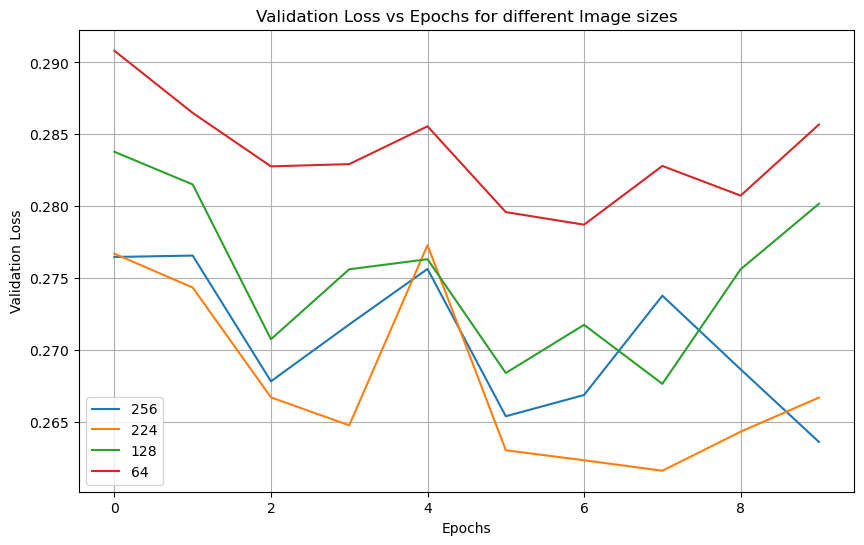

In [26]:
plot_losses(size_exp, 'Validation Loss vs Epochs for different Image sizes')

In [65]:
import torch
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import time
import numpy as np
import pandas as pd

def train_model_history(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, steps=1000, patience=5):
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Define the learning rate scheduler (reduce LR on plateau)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # DataFrame to store history
    history = pd.DataFrame(columns=['epoch', 'val_loss', 'val_auc', 'precision', 'recall', 'f1_score', 'lr', 'train_time', 'val_time', 'epoch_time'])

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f'Starting epoch {epoch+1}/{num_epochs}')
        
        start_time = time.time()  # Start time for training phase

        # Training loop
        for i, batch in enumerate(train_loader):
            if i >= steps:
                break
            images = batch['image'].to(device)
            labels = batch['labels'].to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_time = time.time() - start_time  # End time for training phase

        # Validation at the end of each epoch
        start_time_val = time.time()  # Start time for validation phase

        val_loss, val_auc, val_precision, val_recall, val_f1 = validate_model_history(model, val_loader, criterion)

        val_time = time.time() - start_time_val  # End time for validation phase

        epoch_time = time.time() - start_time  # End time for the entire epoch

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}, '
              f'Training Time: {train_time:.2f}s, Validation Time: {val_time:.2f}s, Total Time: {epoch_time:.2f}s')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f'No improvement in validation loss for {epochs_without_improvement} epoch(s).')

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epochs_without_improvement} epochs without improvement.')
            break

        # Update the learning rate based on validation loss
        scheduler.step(val_loss)
        current_lr = scheduler.optimizer.param_groups[0]['lr']

        # Log metrics into the DataFrame, including time information
        history = pd.concat([history, pd.DataFrame({
            'epoch': [epoch + 1],
            'val_loss': [val_loss],
            'val_auc': [val_auc],
            'precision': [val_precision],
            'recall': [val_recall],
            'f1_score': [val_f1],
            'lr': [current_lr],
            'train_time': [train_time],
            'val_time': [val_time],
            'epoch_time': [epoch_time]
        })], ignore_index=True)

        print(f'Learning rate is updated to {current_lr}')

    model.load_state_dict(best_model_wts)
    print('Training complete. Best Validation Loss:', best_val_loss)

    return model, history  # Return the model and the history DataFrame

def validate_model_history(model, val_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device).float()

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_outputs.append(torch.sigmoid(outputs).cpu().detach().numpy())  # Apply sigmoid
            all_labels.append(labels.cpu().detach().numpy())

    val_loss /= len(val_loader)  # Average validation loss
    all_outputs = np.concatenate(all_outputs)  # Concatenate outputs for AUC calculation
    all_labels = np.concatenate(all_labels)  # Concatenate labels for AUC calculation

    # Threshold outputs for binary predictions
    all_preds = (all_outputs > 0.5).astype(int)

    # Calculate AUC for each label
    auc_scores = []
    for i in range(all_labels.shape[1]):  # Assuming all_labels is shape [num_samples, num_labels]
        if np.unique(all_labels[:, i]).size > 1:  # Check for both classes in the label
            auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)  # If only one class is present, AUC is undefined

    mean_auc = np.nanmean(auc_scores)  # Calculate mean AUC ignoring NaN values

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')

    return val_loss, mean_auc, precision, recall, f1  # Return all metrics


In [61]:
import torch
import torch.nn as nn
import numpy as np

# Code extracted from MIT licensed code Copyright (c) 2021 Alinstein Jose
# Implementation of "Weakly supervised Classification and Localization of Chest X-ray images"
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    Returns
    -------
    list type, with optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
    return list(roc_t['threshold'])


# Idea extacted from the [https://arxiv.org/pdf/1901.05555] paper "Class-Balanced Loss Based on Effective Number of Samples"
# We can normalize inverse frequencies but this method is studied to do better in other works
def effective_weights(class_counts, beta=0.999):
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights)  # Normalize the weights -> or other(?)
    return torch.tensor(weights, dtype=torch.float32)  # Convert to tensor


# Code extracted from MIT licensed code Copyright (c) 2020 Alibaba-MIIL
# Original idea in the [https://arxiv.org/pdf/2009.14119] paper "Asymmetric Loss For Multi-Label Classification"
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True, average=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
        self.average = average

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        # Really small change introduced by thesis author (me) to try average loss impact
        # As discussed in "https://github.com/Alibaba-MIIL/ASL/issues/22" it's not suposed
        # To have an impact but I want to be able to use mean for ease of comparison.
        if self.average:
            return -loss.mean()
        else:
            return -loss.sum()
    

# Function for testing different loss types
def get_loss(loss_type='bce', counts=None, beta=0.99, device='cpu'):
    """
    Returns the appropriate loss function based on the given type.
    
    Args:
        loss_type (str): Either 'bce' for BCEWithLogitsLoss or 'asymmetric' for Asymmetric Loss.
        labels (np.array): A 2D numpy array of shape (num_samples, num_classes) to calculate effective class weights.
        beta (float): Beta parameter for effective number of samples, default is 0.99.
        
    Returns:
        loss_fn (torch.nn.Module): The loss function.
    """
    if loss_type == 'bce':
        loss_fn = nn.BCEWithLogitsLoss()
    elif loss_type == 'bce_w':
        if counts is not None:
            class_weights = effective_weights(counts, beta=beta).to(device)
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        else:
            print("You didn't provide weights so we proceed with normal BCE")
            loss_fn = nn.BCEWithLogitsLoss()
    elif loss_type == 'asymmetric':
        loss_fn = AsymmetricLoss()
    elif loss_type == 'asymmetric_avg':
        loss_fn = AsymmetricLoss(average=True)
    elif loss_type == 'asl1':
        loss_fn = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0)
    elif loss_type == 'asl2':
        loss_fn = AsymmetricLoss(gamma_neg=4, gamma_pos=1, clip=0.05)
    elif loss_type == 'asl3':
        loss_fn = AsymmetricLoss(gamma_neg=8, gamma_pos=1, clip=0.05)
    elif loss_type == 'focal':
        loss_fn = AsymmetricLoss(gamma_neg=2, gamma_pos=2, clip=0)
    
    else:
        raise ValueError(f"Unknown loss_type '{loss_type}'. Use 'bce' or 'asymmetric'.")
    
    return loss_fn

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models import ResNet18_Weights

# Hyperparameters
batch_size = 128
learning_rate = 5e-4
num_epochs = 5
iter_per_epoch = 50
image_size = 256
num_classes = 15

# Paths
train_csv = './labels/train_metadata.csv'
val_csv = './labels/val_metadata.csv'
image_dir = '../resized_images'



print(f'Starting test with bce')

# Data Loaders
dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

print(class_counts)
print(effective_weights(class_counts))
print(torch.sum(effective_weights(class_counts)))

# Model setup
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function and optimizer
counts = np.array(class_counts)
loss_fn = get_loss(loss_type='asymmetric', counts=counts, device=device)
print(loss_fn)
optimizer = get_optimizer(model.parameters(), 'Adam', learning_rate)


# Train the model and log results
model, history = train_model_history(device, model, dataloaders['train'], dataloaders['val'], loss_fn, optimizer, num_epochs, iter_per_epoch)

Starting test with bce
[15661  8262  1863  3280  1639  9533  1727  1145   158 13868  4199  4415
  2424   982  3841]
tensor([0.0440, 0.0440, 0.0521, 0.0457, 0.0546, 0.0440, 0.0535, 0.0645, 0.3009,
        0.0440, 0.0447, 0.0445, 0.0483, 0.0703, 0.0450])
tensor(1.)
AsymmetricLoss()
Starting epoch 1/5
Epoch [1/5], Validation Loss: 92.4180, AUC: 0.6867, Precision: 0.1744, Recall: 0.8379, F1-score: 0.2887, Training Time: 84.63s, Validation Time: 20.00s, Total Time: 104.63s
Learning rate is updated to 0.0005
Starting epoch 2/5


C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/5], Validation Loss: 90.7626, AUC: 0.7089, Precision: 0.1898, Recall: 0.8244, F1-score: 0.3085, Training Time: 43.08s, Validation Time: 19.78s, Total Time: 62.86s
Learning rate is updated to 0.0005
Starting epoch 3/5
Epoch [3/5], Validation Loss: 89.9028, AUC: 0.7157, Precision: 0.2391, Recall: 0.7290, F1-score: 0.3601, Training Time: 30.35s, Validation Time: 19.40s, Total Time: 49.75s
Learning rate is updated to 0.0005
Starting epoch 4/5
Epoch [4/5], Validation Loss: 89.4866, AUC: 0.7301, Precision: 0.2093, Recall: 0.7944, F1-score: 0.3314, Training Time: 36.94s, Validation Time: 19.39s, Total Time: 56.33s
Learning rate is updated to 0.0005
Starting epoch 5/5
Epoch [5/5], Validation Loss: 87.1499, AUC: 0.7509, Precision: 0.2217, Recall: 0.7810, F1-score: 0.3454, Training Time: 70.07s, Validation Time: 19.82s, Total Time: 89.89s
Learning rate is updated to 0.0005
Training complete. Best Validation Loss: 87.14987883134322


ValueError: not enough values to unpack (expected 4, got 2)

In [46]:
import torch

# Convert pred and labels to PyTorch tensors
pred_tensor = torch.tensor([[-7.3645e-01,  5.7881e-01, -2.2020e-01, -5.1094e-01,  2.9868e-01,
                             2.6686e-01,  3.5119e-02, -6.2442e-01, -2.2921e-01,  2.8613e-01,
                             3.6774e-01, -4.4509e-01, -1.0131e+00,  2.7856e-02,  1.0464e+00],
                            [ 5.1233e-01, -2.9292e-02, -8.7824e-02, -8.9985e-01,  6.1635e-01,
                             1.0113e+00,  1.2067e-02, -1.3016e+00,  2.0202e-01, -3.5548e-01,
                            -5.4201e-01, -5.7460e-01, -4.4881e-01,  9.9741e-01,  1.1251e+00],
                            [ 5.9710e-01,  6.8125e-02, -2.9039e-01, -7.9447e-01,  5.1311e-01,
                            -3.1247e-01, -1.2926e-01, -1.1064e+00, -6.4016e-01, -9.4150e-01,
                             1.9711e-01, -4.3601e-01, -6.0893e-01,  6.6210e-02,  5.9627e-01],
                            [-1.4584e-01,  1.2339e-01, -9.8124e-02, -5.5506e-01,  6.5351e-01,
                             3.3160e-01, -1.7156e-01, -5.0052e-01, -3.9164e-01,  2.6694e-01,
                             5.2570e-01,  2.9331e-02, -7.3786e-01,  1.6505e-01,  8.5180e-01],
                            [ 3.7813e-01,  1.6255e-01, -1.9692e-01, -5.3570e-01,  8.5489e-01,
                             1.0920e+00,  3.0120e-01, -9.9126e-01, -6.8351e-02, -5.0176e-01,
                            -5.2612e-01, -7.2143e-01, -6.2451e-01,  5.1360e-01,  1.0608e+00],
                            [ 7.1772e-01,  5.5271e-01, -3.9907e-01, -1.2032e+00,  5.2024e-01,
                             2.2213e-01, -7.2604e-02, -1.0538e+00, -3.7901e-01, -5.6711e-01,
                             2.4622e-01, -3.0617e-01, -2.3560e-02,  1.0056e-01,  7.4420e-01]])

labels_tensor = torch.tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                              [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
                              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Paths
train_csv = './labels/train_metadata.csv'
val_csv = './labels/val_metadata.csv'
image_dir = '../resized_images'



print(f'Starting test with bce')

# Data Loaders
dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

print(class_counts)
print(effective_weights(class_counts))
print(torch.sum(effective_weights(class_counts)))

# Loss function and optimizer
counts = np.array(class_counts)
for loss in ['asymmetric','focal','bce_w','bce']:
    loss_fn = get_loss(loss_type=loss, counts=counts)
    print(loss_fn)

    curr_loss = loss_fn(pred_tensor, labels_tensor)
    print(f"{loss} Loss: {curr_loss.item()}")

Starting test with bce
[15661  8262  1863  3280  1639  9533  1727  1145   158 13868  4199  4415
  2424   982  3841]
tensor([0.0440, 0.0440, 0.0521, 0.0457, 0.0546, 0.0440, 0.0535, 0.0645, 0.3009,
        0.0440, 0.0447, 0.0445, 0.0483, 0.0703, 0.0450])
tensor(1.)
AsymmetricLoss()
asymmetric Loss: 6.669809341430664
AsymmetricLoss()
focal Loss: 18.099987030029297
BCEWithLogitsLoss()
bce_w Loss: 0.6151524186134338
BCEWithLogitsLoss()
bce Loss: 0.6771169900894165


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models import ResNet18_Weights

# Hyperparameters
batch_size = 128
learning_rate = 5e-4
num_epochs = 20
iter_per_epoch = 50
image_sizes = 256
num_classes = 15

# Paths
train_csv = './labels/train_metadata.csv'
val_csv = './labels/val_metadata.csv'
image_dir = '../resized_images'

# Storage matrices
histories = {}


# Test each combination of batch size and learning rate
for loss_func in ['bce','bce_w','focal','asymmetric','asymmetric_avg','asl1','asl2','asl3']:
    print(f'Starting test with loss = {loss_func}')

    # Data Loaders
    dataloaders, dataset_sizes, class_counts = make_data_loaders(train_csv, val_csv, image_dir, batch_size, image_size)

    # Model setup
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Loss function and optimizer
    counts = np.array(class_counts)
    loss_fn = get_loss(loss_type=loss_func, counts=counts, device=device)
    optimizer = get_optimizer(model.parameters(), 'Adam', learning_rate)

    # Train the model and log results
    model, history = train_model_history(device, model, dataloaders['train'], dataloaders['val'], loss_fn, optimizer, num_epochs, iter_per_epoch)

    histories[loss_func] = history

Starting test with loss = bce
Starting epoch 1/20
Epoch [1/20], Validation Loss: 0.2498, AUC: 0.6910, Precision: 0.5099, Recall: 0.1345, F1-score: 0.2129, Training Time: 33.06s, Validation Time: 20.53s, Total Time: 53.59s
Learning rate is updated to 0.0005
Starting epoch 2/20


C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 0.2455, AUC: 0.7155, Precision: 0.5577, Recall: 0.1011, F1-score: 0.1712, Training Time: 32.66s, Validation Time: 20.44s, Total Time: 53.09s
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 0.2468, AUC: 0.7235, Precision: 0.5696, Recall: 0.0785, F1-score: 0.1381, Training Time: 34.52s, Validation Time: 21.42s, Total Time: 55.94s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 0.2491, AUC: 0.7257, Precision: 0.5315, Recall: 0.1575, F1-score: 0.2430, Training Time: 34.67s, Validation Time: 21.13s, Total Time: 55.79s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 0.2520, AUC: 0.7408, Precision: 0.4638, Recall: 0.1952, F1-score: 0.2748, Training Time: 35.02s, Validation Time: 21.18s, Total Time: 56.20s
No improvement in validation loss for 3 epoch(s

c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [1/20], Validation Loss: 0.0339, AUC: 0.5845, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 33.84s, Validation Time: 23.03s, Total Time: 56.87s
Learning rate is updated to 0.0005
Starting epoch 2/20


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/20], Validation Loss: 0.0330, AUC: 0.6288, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 34.13s, Validation Time: 21.19s, Total Time: 55.32s
Learning rate is updated to 0.0005
Starting epoch 3/20


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/20], Validation Loss: 0.0325, AUC: 0.6625, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 33.28s, Validation Time: 20.86s, Total Time: 54.14s
Learning rate is updated to 0.0005
Starting epoch 4/20


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/20], Validation Loss: 0.0321, AUC: 0.7000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 33.29s, Validation Time: 20.73s, Total Time: 54.03s
Learning rate is updated to 0.0005
Starting epoch 5/20


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/20], Validation Loss: 0.0322, AUC: 0.6998, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 33.46s, Validation Time: 20.84s, Total Time: 54.29s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 6/20


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/20], Validation Loss: 0.0324, AUC: 0.7156, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 33.25s, Validation Time: 20.77s, Total Time: 54.01s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 7/20


c:\Users\hugoa\anaconda3\envs\cuda_dev_1\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/20], Validation Loss: 0.0320, AUC: 0.7171, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, Training Time: 33.38s, Validation Time: 20.80s, Total Time: 54.18s
Learning rate is updated to 0.0005
Starting epoch 8/20
Epoch [8/20], Validation Loss: 0.0316, AUC: 0.7303, Precision: 1.0000, Recall: 0.0001, F1-score: 0.0002, Training Time: 41.63s, Validation Time: 20.80s, Total Time: 62.43s
Learning rate is updated to 0.0005
Starting epoch 9/20
Epoch [9/20], Validation Loss: 0.0345, AUC: 0.7168, Precision: 0.4000, Recall: 0.0010, F1-score: 0.0020, Training Time: 33.38s, Validation Time: 20.77s, Total Time: 54.15s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 10/20
Epoch [10/20], Validation Loss: 0.0315, AUC: 0.7430, Precision: 0.6667, Recall: 0.0004, F1-score: 0.0008, Training Time: 33.38s, Validation Time: 20.83s, Total Time: 54.22s
Learning rate is updated to 0.0005
Starting epoch 11/20
Epoch [11/20], Validation Loss: 0.0321,

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 129.6979, AUC: 0.7037, Precision: 0.5615, Recall: 0.0527, F1-score: 0.0964, Training Time: 33.24s, Validation Time: 27.98s, Total Time: 61.22s
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 128.0022, AUC: 0.7257, Precision: 0.5324, Recall: 0.1325, F1-score: 0.2122, Training Time: 33.18s, Validation Time: 28.12s, Total Time: 61.30s
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 125.6513, AUC: 0.7241, Precision: 0.5609, Recall: 0.1011, F1-score: 0.1714, Training Time: 33.11s, Validation Time: 27.86s, Total Time: 60.97s
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 123.8295, AUC: 0.7415, Precision: 0.5559, Recall: 0.1305, F1-score: 0.2114, Training Time: 33.20s, Validation Time: 35.40s, Total Time: 68.60s
Learning rate is updated to 0.0005
Starting epoch 6/20
Epoch [6/20], Validation Loss: 126.3749, AUC: 0.7439, Precision: 0.5090, Recall: 0.1

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 90.2793, AUC: 0.7077, Precision: 0.1834, Recall: 0.8335, F1-score: 0.3007, Training Time: 33.23s, Validation Time: 27.98s, Total Time: 61.21s
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 85.6955, AUC: 0.7330, Precision: 0.2337, Recall: 0.7666, F1-score: 0.3582, Training Time: 37.45s, Validation Time: 28.21s, Total Time: 65.66s
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 92.8788, AUC: 0.7335, Precision: 0.1787, Recall: 0.8432, F1-score: 0.2949, Training Time: 33.26s, Validation Time: 27.89s, Total Time: 61.15s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 87.3989, AUC: 0.7438, Precision: 0.2069, Recall: 0.8201, F1-score: 0.3305, Training Time: 33.14s, Validation Time: 28.10s, Total Time: 61.24s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Starting

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 0.0464, AUC: 0.7075, Precision: 0.2140, Recall: 0.7659, F1-score: 0.3346, Training Time: 33.25s, Validation Time: 27.97s, Total Time: 61.22s
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 0.0469, AUC: 0.7243, Precision: 0.2303, Recall: 0.7209, F1-score: 0.3491, Training Time: 70.42s, Validation Time: 28.34s, Total Time: 98.77s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 0.0475, AUC: 0.7387, Precision: 0.2083, Recall: 0.7784, F1-score: 0.3287, Training Time: 88.83s, Validation Time: 28.02s, Total Time: 116.85s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 0.0458, AUC: 0.7474, Precision: 0.2122, Recall: 0.8122, F1-score: 0.3365, Training Time: 88.76s, Validation Time: 30.07s, Total Time: 118.83s
Learning rate is updated to 0.0005
Starting e

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 176.2962, AUC: 0.7101, Precision: 0.4492, Recall: 0.2248, F1-score: 0.2997, Training Time: 53.79s, Validation Time: 28.06s, Total Time: 81.85s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 171.8403, AUC: 0.7256, Precision: 0.4665, Recall: 0.2514, F1-score: 0.3267, Training Time: 53.79s, Validation Time: 27.99s, Total Time: 81.77s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 178.8801, AUC: 0.7316, Precision: 0.3793, Recall: 0.3414, F1-score: 0.3593, Training Time: 53.76s, Validation Time: 28.05s, Total Time: 81.81s
No improvement in validation loss for 3 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 169.1341, AUC: 0.7487, Precision: 0.4557, Recall: 0.2943, F1-score: 0.3576, Training Time: 53.79s, Validation Time: 28.13s, Total Ti

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 89.9233, AUC: 0.7095, Precision: 0.2114, Recall: 0.7784, F1-score: 0.3325, Training Time: 53.85s, Validation Time: 27.93s, Total Time: 81.78s
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 86.8785, AUC: 0.7364, Precision: 0.2356, Recall: 0.7427, F1-score: 0.3577, Training Time: 88.48s, Validation Time: 28.10s, Total Time: 116.58s
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 88.9436, AUC: 0.7428, Precision: 0.1905, Recall: 0.8367, F1-score: 0.3104, Training Time: 88.25s, Validation Time: 27.93s, Total Time: 116.18s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 91.3895, AUC: 0.7498, Precision: 0.1813, Recall: 0.8781, F1-score: 0.3005, Training Time: 88.23s, Validation Time: 28.01s, Total Time: 116.25s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Start

C:\Users\hugoa\AppData\Local\Temp\ipykernel_4916\3829860847.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, pd.DataFrame({


Epoch [2/20], Validation Loss: 47.2972, AUC: 0.7069, Precision: 0.0948, Recall: 0.9996, F1-score: 0.1731, Training Time: 53.60s, Validation Time: 28.21s, Total Time: 81.81s
Learning rate is updated to 0.0005
Starting epoch 3/20
Epoch [3/20], Validation Loss: 46.2397, AUC: 0.7305, Precision: 0.0969, Recall: 0.9990, F1-score: 0.1766, Training Time: 88.50s, Validation Time: 28.14s, Total Time: 116.64s
Learning rate is updated to 0.0005
Starting epoch 4/20
Epoch [4/20], Validation Loss: 46.3730, AUC: 0.7437, Precision: 0.1006, Recall: 0.9986, F1-score: 0.1828, Training Time: 88.50s, Validation Time: 28.30s, Total Time: 116.80s
No improvement in validation loss for 1 epoch(s).
Learning rate is updated to 0.0005
Starting epoch 5/20
Epoch [5/20], Validation Loss: 48.8062, AUC: 0.7282, Precision: 0.1026, Recall: 0.9975, F1-score: 0.1860, Training Time: 90.56s, Validation Time: 29.70s, Total Time: 120.26s
No improvement in validation loss for 2 epoch(s).
Learning rate is updated to 0.0005
Start

KeyboardInterrupt: 

In [50]:
criterion_exp = {}
criterions = ['asymmetric','focal','bce_w','bce','asymmetric_avg','asl1','asl2','asl3']

for i in range(4):
    criterion_exp[criterions[i]] = final_val_aucs[i]

In [69]:
for key, df in histories.items():
    # Save each DataFrame as "key.csv"
    filename = f"./{key}.csv"
    df.to_csv(filename, index=False)  # Set index=False if you don't want to store the index in the CSV
    print(f"Saved {key} as {filename}")

Saved bce as ./bce.csv
Saved bce_w as ./bce_w.csv
Saved focal as ./focal.csv
Saved asymmetric as ./asymmetric.csv
Saved asymmetric_avg as ./asymmetric_avg.csv
Saved asl1 as ./asl1.csv
Saved asl2 as ./asl2.csv


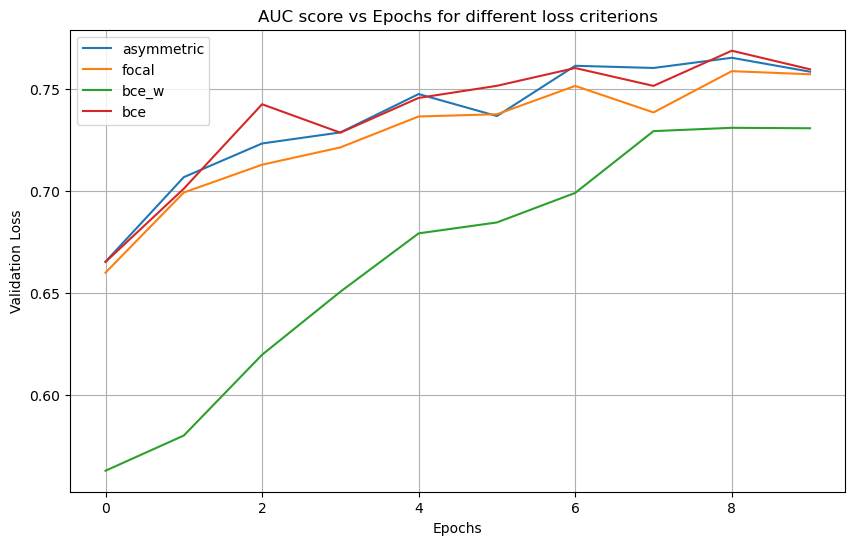

In [53]:
plot_losses(criterion_exp, 'AUC score vs Epochs for different loss criterions')